# Statistical Arbitrage in Brazilian Stocks

## Sumary
- [Introduction](#Introduction)
- [In Sample Out-Sample Split Data](#In-Sample-Out-Sample-Split-data)
- [Selection Pairs using Cointegration Test](#Selection-Pairs-using-Cointegration/Correlation-Test)
- [BackTesting-our-Hipotheses](#BackTesting-our-Hipotheses)
- [Optimizing the Parameters](#Optimization-in-one-Pair-PETR3-<=>-PETR4)
- [Results comparing In-Sample and Out-Sample Data](#)
- [Table of Results](#)
- [Conclusion and Further works](#)
- [References](#References)

## Introduction
__Description__: The project show the implementation of statistical arbitrage in brazilian stock market

__Setup Data Period__: start in Jan-2011 and end of Dec-2011

__In-Sample Data Period__: start in Jan-2012 to end of Dec-2015

__Out-Sample Data Period__: start in Jan- 2016 to end of Dec-2016

__Stock List__: VALE3, BBDC3, CIEL3, BBAS3, LREN3, ITUB3, LAME4, GGBR4, PETR4, USIM5, ITSA4, UGPA3, PETR3, VALE5, BVMF3, GOAU4, ITUB4, ABEV3, BBDC4



## Download and Split Data into In-Sample Out-Sample 
<br/>

<div style="text-align: justify;"> 
We download all data from a broker of brazil stock, because data in google finance and yahoo finance have a lot of missing days in brazilian stocks.
<br/><br/>
The data was broked into three pieces, because i want to optimize the parameters, so to avoid overfitting, i must using insample to optimize and out of sample to validate and confirm if my backtest results are more stronger. I also use the third period of data called here as setup period , because a want be more realist with my results, so a run the selection of pair in this part of data, take the best pair after that, optimize the parameters over in-sample period to each pair selected in selection pair and took the best parameters into a out-sample period of data to collect the results, this is the Table of Results part.</div>

In [1]:
import warnings
warnings.filterwarnings("ignore")

from backtest_functions import *;
import matplotlib.pyplot as plt;

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 6); # set the default image size

Populating the interactive namespace from numpy and matplotlib


In [2]:
# split data 
#insample_df, outsample_df = train_test_split(prices_df, test_size=0.25, shuffle=False, stratify=None);
setup_df = prices_df.ix['2011':'2011']
insample_df = prices_df.ix['2012':'2015']
outsample_df = prices_df.ix['2016':'2016']


## Selection Pairs using Cointegration/Correlation Test
<div style="text-align: justify;"> <br/>
We run this cointegration test in our setup dataset (start in 2011 to 2012), we do this to avoid the look in to future bias,  i will explain in detail in backtest part (in a loopback part of filter), but to breaf, when we are in backtest we have all data so basicaly we can have look in to data and indicator are days ahead in time, but in real life we can't so to have more realistic results, we made this split.
</div>

### Cointegration-Test

<div style="text-align: justify;"> <br/>
In this work we will use test of cointegration called the Augmented Dickey-Fuller.


<br/>
We will run a dickey fuller test into all list of stocks, to see which pair are cointegrated, to do this we are using the http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html. 

</div>
<div style="text-align: justify;"> <br/>
The table below display only the pair which met our criteria, that is cointegration test with with p-value less than 0.05  (5%) and correlation greater than .60 (60%) (like was suggest on class). 
The p-value of dickey fuller test is a column called *__dickey_pvalue__* and *__correlation__* is the result of correlation test.
</div>

In [3]:
coin_df=cointegration_to_df(stock_list, setup_df); corr_df=correl_to_df(stock_list, setup_df);
# merge two dataframes
pairs_df = pd.merge(coin_df, corr_df, how='outer', on=['A','B'])

# filter only cor>.6 and dickey<.05
pairs_df = pairs_df[ (pairs_df.dickey_pvalue<0.05) & (pairs_df.correlation>.85)]

# Make colums more visibles
pairs_df = pairs_df[["A", "B", "dickey_pvalue", "correlation"]]
pairs_df.columns=["Stock A", "Stock B", "Dickey p-Value", "Correlation"]
pairs_df.sort_values(["Dickey p-Value", "Correlation"], inplace=True)
pairs_df

,Stock A,Stock B,Dickey p-Value,Correlation
61,BVMF3,ITUB4,0.000207,0.922264
65,BVMF3,ITUB3,0.000298,0.870107
148,BBAS3,USIM5,0.000363,0.862915
1,BBDC4,ITSA4,0.001261,0.931434
35,ITSA4,BVMF3,0.001770,0.920976
13,BBDC4,ITUB4,0.004790,0.924510
84,GOAU4,GGBR4,0.005159,0.998206
118,VALE3,BBAS3,0.012664,0.891425
85,GOAU4,BBAS3,0.017913,0.859227
135,GGBR4,BBAS3,0.020313,0.859025


Now we can go further and start make a backtest.

In [4]:
stockA, stockB = "PETR4", "PETR3"

df = insample_df.ix['2014':'2014']
df = back_build_df(df[stockA], df[stockB], df.index)
df = back_buildratio(df, devpad=2, loopback_period=20)

## BackTesting our Hipotheses 
<div style="text-align: justify;"> <br/>
Statistical Arbitrage is a hypothesis, that is two different stocks or assets, are moving together, but after some time, they diverge from the mean of this pair, and after some period of time, they tend to converge to the mean, we have some great tools to validate if two assets have higher probability to converge rather than others pair, like dickey fuller test.
In other word, we try find some assets thats usually move togheter, but because some especulation, or news, or whenever in one of legs, one of the price (or both) of this pair move away, but because we know the two stocks are cointegrated, the price tend to go back to value of mean.
</div> 
<div style="text-align: justify;"> <br/>
We first build a indicator called Pair Ratio, that is the StockA Close Price / StockB Close Price, and also other two statistics:</div>

- __PairRatio__: ClosePrice Stock A / ClosePrice Stock B
- __PairMeans__: 20 days Means 
- __StdDev__: 2 Standard Deviation

<div style="text-align: justify;"> <br/>
After we calculated the standard deviation and means, we will see when *__PairRatio__* go beyond the two standard deviation (there is the dotted blue line), thats our trigger to enter a pair position, the chart below, show us some examples:
</div>

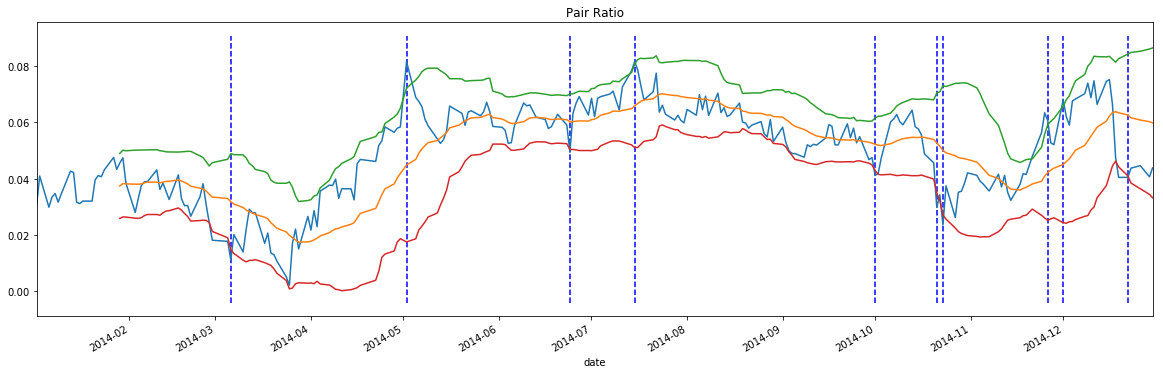

In [5]:
plot_ratio(df)

This is the *__PairRatio__* of __PETR3__ and __PETR4__, one of most famous company in brazilian stock market.

<div style="text-align: justify;"> <br/>
If you are familiar with traditional techinal analisys, you may be noted that a bollinger band applied to a *__PairRatio__*. 
To gave a more convenient way to detect when PairRatio touch in two standard deviation band we will calculate a indicator called z-score, it simple means:
</div>
- If z-score greater than 2: price touch the upper band of 2 standard deviation 
- if z-score lower than -2: price touch the upper band of -2 standard deviation

The chart below show the z-score of same period of PairRatio chart:

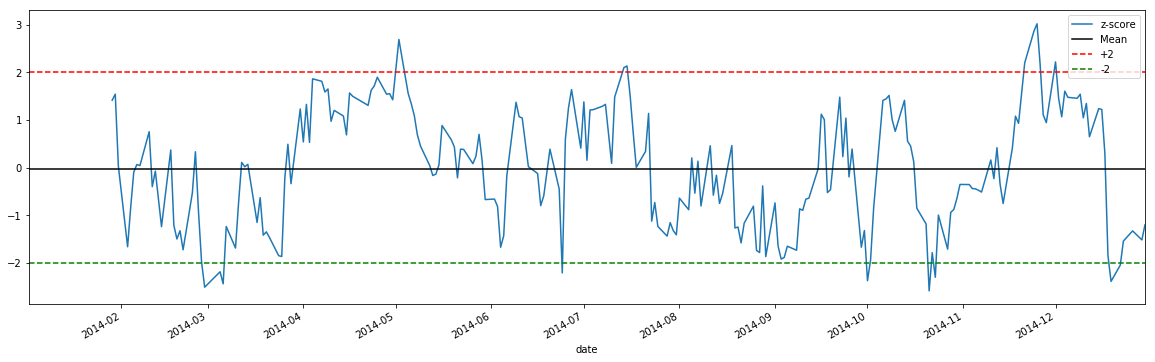

In [6]:
plot_zscore(df)

<div style="text-align: justify;"> <br/>
To end this part i will show a snapshot of dataframe we use to calculate PairRatio and Zscore, and proceed other steps of backtest:</div>

In [7]:
df.tail(5)

,A,B,ratio,mean_ratio,upperline,lowerline,zscore
date,,,,,,,
2014-12-22,10.32,9.91,0.040539,0.062660,0.084286,0.041034,-2.045773
2014-12-23,10.97,10.50,0.043789,0.061677,0.084882,0.038472,-1.541763
2014-12-26,10.30,9.85,0.044672,0.060877,0.085299,0.036455,-1.327076
2014-12-29,10.28,9.87,0.040700,0.060277,0.086094,0.034459,-1.516534
2014-12-30,10.02,9.59,0.043862,0.059864,0.086482,0.033246,-1.202339





## Basic Strategy of Pair Trading
we are now focus on the basic rules to entry and exit into trades:

- __Go "Long" the pair whenever the z-score is below -2.0:__

that means, we will: 
    - BUY the stock A. 
    - SHORT the stock B. 
    
- __Go "Short" the pair when the z-score is above 2.0:__

that means, we will: 
    - SHORT the stock A. 
    - BUY the stock B. 

* __Exit positions when the z-score less than 0.5 or greater than -0.5:__

thats means, usually, our take profit.
    
* __Exit positions when the z-score greater than 3 or lower than -3:__

thats means, usually, our stop loss.


<div style="text-align: justify;"> <br/>
Again, don't get confuse about z-score, remember is like a bollinger band's indicator, when z-score is lower then -2, it's simple means your price is lower than two standard deviation.
</div>


In [8]:
df, stats = back_complete(insample_df, "PETR4", "PETR3", adf_loopback_1=25)

## A Engine to do a Backtest
Theres a lot of functions in backstage, all functions is inside of backtest_functions.py script, if you want you can take a look, to use or improve, would be nice. I not explain one by one, because is not inteend of this work, i only take a overview of most importants functions:
#### List of functions
- __back_build_df:__ This function receive the prices_df, and create columns two column A with close price of stock A and column B with close price of stock B, to our backtest.

- __back_buildratio:__ Calculate PairRatio and Z-Score.

- __back_filter:__ Calculate adf p-value of dickey fuller test and correlation using X days loopback period, after that deliver the column 'filter' to see when filters are ok.

- __back_signals:__ Calculate the Pnl columns using z-score columns, we should calculate use back_buildratio first.

- __back_get_stats:__ get statistics from a dataframe thats already make a backtest, that means we already run function back_signals and other as well.

Below a example of result dataframe, after running a backtest:

In [9]:
print(df.ix['2015-01-01':'2015-02-01'].tail(5))

                A     B     ratio  mean_ratio  upperline  lowerline    zscore  \
date                                                                            
2015-01-26   9.91  9.54  0.038051    0.032085   0.056915   0.007254  0.480536   
2015-01-27  10.17  9.64  0.053521    0.032527   0.058587   0.006468  1.611201   
2015-01-28   9.03  8.63  0.045308    0.032758   0.059200   0.006315  0.949236   
2015-01-29   8.75  8.47  0.032523    0.032191   0.058112   0.006269  0.025651   
2015-01-30   8.18  8.04  0.017263    0.031093   0.057614   0.004572 -1.042944   

            filter  filter_adf_1  corr_calc  filter_corr_1  signal  status  \
date                                                                         
2015-01-26   False      0.167121   0.982251           True       0       0   
2015-01-27   False      0.147638   0.979753           True       0       0   
2015-01-28   False      0.374792   0.975449           True       0       0   
2015-01-29   False      0.591916   0.97500

### Avoiding Look Ahead Future Bias
<div style="text-align: justify;"> <br/>
You may notice we keep calculate the dickey_fuller test and even the the correlation test, in backtest dataframe, why we do this? 

<br/><br/>

In first test we made in this project,(Selection Pair step) when we run a dickey fuller test in all pairs avaliable, when we this test we get just a single answer, if the pair are cointegrated or not, or if there are correlation beetween two stocks or not, but in reality the result of this test may change through time, to a single pair, or a group of pairs. 

<br/><br/>

For example, if you look to 20 days correlation between __UGPA3 and CIEL3__ in a year of 2014 they was __96% correlated__ (0.96063) in __2014-04-09__, but in __2014-06-05__ the correlation drops to __-62% correlated__ (-0.62189). If our trigger is only trade pairs 60% correlation, is this situation we don't want take a trade even though our z-score go below -2 or above +2, so that's the reason we should keep calculate the dickey_fuller using 25 days loopback period and correlation using 20 days loopback period. 
</div>

The graphic below draw a horizontal line in two situations, the first is where price is correlated with 96% and second with -62%.

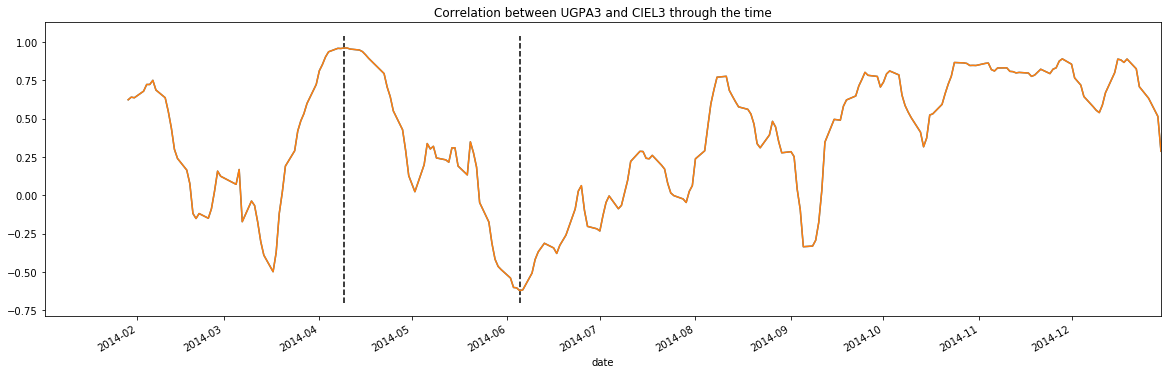

In [10]:
stockA, stockB = "UGPA3", "CIEL3"

df = insample_df.ix['2014':'2014']
df = back_build_df(df[stockA], df[stockB], df.index)
df = back_buildratio(df, devpad=2, loopback_period=20)
df = back_filters(df)
df.corr_calc.plot()

ax = df.corr_calc.plot(title="Correlation between {} and {} through the time".format(stockA, stockB));
min_corr, max_corr = df.corr_calc.describe()["min"], df.corr_calc.describe()["max"]
dates = [df[ (df.corr_calc == min_corr) | (df.corr_calc == max_corr) ].index]
ymin, ymax = ax.get_ylim()
ax.vlines(x=dates, ymin=ymin, ymax=ymax, color='black', linestyle='--')
min_corr, df[df.corr_calc == min_corr].index, max_corr, df[df.corr_calc == max_corr].index;

The same behavior we can found in p-value of dickey fuller test, as well:

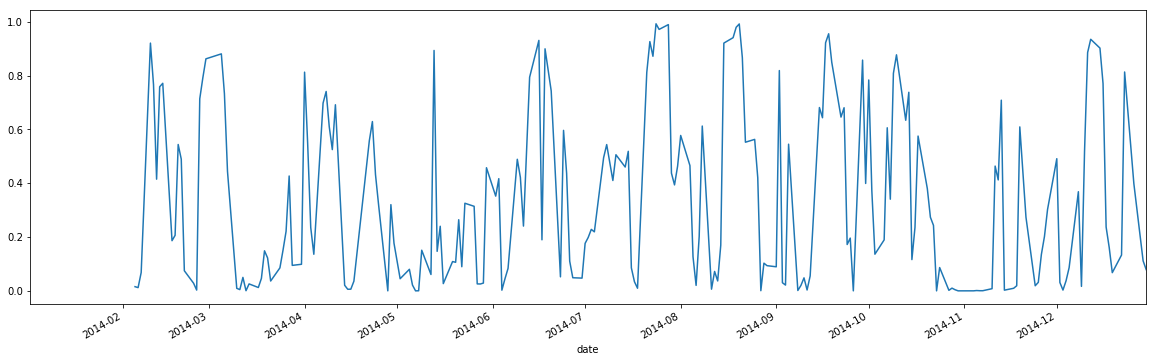

In [11]:
df.filter_adf_1.plot();


Now, is more easy to explain the __filter__ column: 
* When is __True__ means if we a have a buy or sell signal we __can take a trade__
* When is __False__ means even if we a have a buy or sell signal we __cannot take a trade__



In [12]:
df_examples, stats = back_complete(insample_df, "PETR4", "PETR3", adf_loopback_1=0);

### Example of Buy Signal 

Now after this couple of functions, we can perform a backtest and take a look into a buy signal example. 


In [13]:
df_buy = df_examples.ix['2014-04-30':'2014-05-12'];
df_buy[['A', 'B', 'ratio', 'upperline', 'lowerline', 'zscore', 'filter', 'signal', 'status', 'entry_priceA', 'entry_priceB', 'pnl']]

,A,B,ratio,upperline,lowerline,zscore,filter,signal,status,entry_priceA,entry_priceB,pnl
date,,,,,,,,,,,,
2014-04-30,16.57,15.63,0.058402,0.065054,0.018735,1.425548,True,1,1,14.83,14.44,0.00
2014-05-02,17.60,16.22,0.081654,0.072206,0.017569,2.691679,True,1,1,14.83,14.44,0.00
2014-05-05,17.57,16.40,0.068912,0.075104,0.018695,1.560920,True,1,1,14.83,14.44,0.00
2014-05-06,18.24,17.05,0.067467,0.076388,0.021858,1.345598,True,1,1,14.83,14.44,0.00
2014-05-07,18.58,17.40,0.065616,0.078058,0.023189,1.092910,True,1,1,14.83,14.44,0.00
2014-05-08,17.88,16.82,0.061114,0.078907,0.024675,0.687631,True,0,1,14.83,14.44,0.00
2014-05-09,17.67,16.66,0.058858,0.079285,0.026423,0.454261,True,0,2,14.83,14.44,-0.62
2014-05-12,18.03,17.08,0.054129,0.079285,0.027846,0.043794,True,0,0,0.00,0.00,0.00


There are few things occours in this trade (The trade begin at 2 of April in 2014):
 
__Entry__: 
* When the ratio going higher than upperband (column: upperline), so basically 
* Ratio>upperline (or 0.081654>0.072206), and *__z-score__* go greater than *__2__*
* Our *__Signal__* column go to *__+1__*, because a *__buy signal__* was generated and we compute *__entry_prices__* (A/B)
* Status column was updated also with +1 and carry this status through cells below, until exit signal was generated (day 2014-05-09)
  
__Exit__:
* When *__z-score__* go lower than 0.5, in this case 0.454261
* Our *__Signal__* column go to *__+2__*, that means we are *__exiting a buy signal__*
* The *__Pnl__* column was update using the entry_price column and the actual price column to calculate the pnl of trade *__(.37)__*


### Example of Sell  Signal 

There are also a example of sell signal, we can see in the snapshot below:

In [14]:
df_sell = df_examples.ix['2014-02-27':'2014-03-13']
df_sell[['A', 'B', 'ratio', 'upperline', 'lowerline', 'zscore', 'filter', 'signal', 'status', 'entry_priceA', 'entry_priceB', 'pnl']]

,A,B,ratio,upperline,lowerline,zscore,filter,signal,status,entry_priceA,entry_priceB,pnl
date,,,,,,,,,,,,
2014-02-27,13.19,12.87,0.024560,0.044554,0.024493,-1.986575,True,-1,-1,13.19,12.87,0.00
2014-02-28,12.77,12.54,0.018175,0.045738,0.021288,-2.509281,True,-1,-1,13.19,12.87,0.00
2014-03-05,12.49,12.27,0.017771,0.046935,0.019061,-2.185144,True,-1,-1,13.19,12.87,0.00
2014-03-06,12.62,12.48,0.011155,0.048925,0.014886,-2.438385,True,-1,-1,13.19,12.87,0.00
2014-03-07,12.51,12.26,0.020186,0.048594,0.013471,-1.235163,True,-1,-1,13.19,12.87,0.00
2014-03-10,12.22,12.05,0.014009,0.048484,0.011086,-1.687307,True,-1,-1,13.19,12.87,0.00
2014-03-11,12.32,12.05,0.022159,0.047403,0.010478,-0.734628,True,0,-1,13.19,12.87,0.00
2014-03-12,12.51,12.15,0.029199,0.045454,0.011031,0.111148,True,0,-2,13.19,12.87,0.04
2014-03-13,12.32,11.98,0.027985,0.044626,0.011035,0.018488,True,0,0,0.00,0.00,0.00


There are few things occours in this trade (The trade begin at 28 of February in 2014):
 
__Entry__: 
* When the ratio going lower than lowerband (column: lowerline), so
* Basically ratio<lowerline (or 0.018175<0.021288), and *__z-score__* go lower than -2
* Our *__Signal__* column go to *__-1__*, because a *__sell signal__* was generated and we compute *__entry_prices__* (A/B)
* *__Status__* column was updated with also *__-1__* and carry this status through cells below, until exit signal was generated (day 2014-03-12)
  
__Exit__:
* When *__z-score__* go greater than -0.5, in this case 0.111148
* Our *__Signal__* column go to *__-2__*, that means we are *__exiting a sell signal__*
* The *__Pnl__* column was update using the entry_price column and the actual price column to calculate the pnl of trade *__(.13)__*


### Complete backtest  between PETR4 and PETR3 and some statistics
To complete this part, and start look to optimization's we will run a backtest using the stardard parameter's:

* LoopBack Period to PairRatio and Z-Score: 20 periods
* Adf test to Filter with 50 loopback period and p-value .05
* Correlation test to filter with 20 days loopback and correlation bigger than .60
* Z-Score greater than +1 to entry to Buy Signal and Z-Score lower than -1 to Sell Signal
* Z-Score less than +0.5 and grater than -0.5 to exit trade (take profit)
* Z-Score greater than +2 or lower than -2 exit trade (stop)

The result are demonstrated below:

In [15]:
df_backtest, stats = back_complete(insample_df, "PETR3", "PETR4", adf_loopback_1=50, z_entry=1.5, z_exit=0.5, z_stop=3);

def print_results(dict_stats):
    df_r = pd.DataFrame(dict_stats, index=[0])
    df_r=df_r[["A", "B","trades", "hit_ratio", "cagr", "sharpe_ratio", "return"]]
    df_r.columns=["Stock A", "Stock B", "Total Trades", "Hit Ratio", "CAGR", "Sharpe Ratio", "Return"]
    return df_r

print_results(stats)
#CAGR - Percent so 90%
#Return - Percent

,Stock A,Stock B,Total Trades,Hit Ratio,CAGR,Sharpe Ratio,Return
0,PETR3,PETR4,22,0.681818,0.128181,0.012813,0.62


- __Total:__ 22 Trades
- __CAGR:__ 12.81% 
- __Sharpe Ratio__: 0.01
- __Return__: 62%
- __Win Ratio__: 68.18%

The results is are not bad, but not good either, let's see if we can optimize this results.

# Optimization in one Pair PETR3 <=> PETR4

Optimization is a process when change some parameters of our strategy to see if we can get better results in our backtest,  use z-score to entry at +2 or -2 one example, this values are some standards to pair trading, but maybe not real the best choice to PETR4 and PETR3 stocks, for example, so we can change to +1 and -1 and see if improve the results. We don't need do it manually, that's the reason we a have a *__function__* called *__opt_signals__*. This function will iterate to all groups of choices, for example, if we wanna test z-score to entry we can pass opt_signals( z_entry_range= [1, 2] ), so in this situation we will make a backtest using z-score >+1 and z-score<-1, a colect the results, and run again with z-score >+2 and z-score<-2 and put in dataframe, here this example in PETR4, PETR3:

In [16]:
stockA, stockB = "PETR3", "PETR4"
df = back_build_df(insample_df[stockA], insample_df[stockB], insample_df.index)
better_index, results_df = opt_signals(df, 
                                       z_entry_range=[1,2], 
                                       z_exit_range=[0.5], 
                                       z_stop_range=[3], 
                                       fake=False, debug=False)
results_df

,cagr,entry_devpad,entry_loopback,filter_adf,filter_corr,hit_ratio,return,sharpe_ratio,trades,z_entry,z_exit,z_stop
1,0.259941,2,20,50,0.6,0.743590,1.52,0.030704,39,1,0.5,3
0,0.251099,2,20,0,0.6,0.746988,1.45,0.016620,83,1,0.5,3
2,0.057371,2,20,0,0.6,0.675676,0.25,0.003226,37,2,0.5,3
3,-0.069395,2,20,50,0.6,0.583333,-0.25,-0.006074,12,2,0.5,3


I'm not go further in explanation of function opt_signal, but when we put another group of parameters like z_entry_range=[1,2] and z_exit_range=[0.7 , 0.5] the function will make a product of groups parameters, I means we will test:
* __z_entry = 2__ with __z_exit = 0.7__ and collect the results
* __z_entry = 2__ with __z_exit = 0.5__ and collect the results
* __z_entry = 1__ with __z_exit = 0.7__ and collect the results
* __z_entry = 1__ with __z_exit = 0.5__ and collect the results


Here an example:

In [17]:
stockA, stockB = "PETR3", "PETR4"
df = back_build_df(insample_df[stockA], insample_df[stockB], insample_df.index)
better_index, results_df = opt_signals(df, 
                                       z_entry_range=[1,2], 
                                       z_exit_range=[0.5, 0.7], 
                                       z_stop_range=[3], 
                                       fake=False, debug=False)
results_df

,cagr,entry_devpad,entry_loopback,filter_adf,filter_corr,hit_ratio,return,sharpe_ratio,trades,z_entry,z_exit,z_stop
2,0.402580,2,20,0,0.6,0.780000,2.87,0.032113,100,1,0.7,3
1,0.259941,2,20,50,0.6,0.743590,1.52,0.030704,39,1,0.5,3
0,0.251099,2,20,0,0.6,0.746988,1.45,0.016620,83,1,0.5,3
3,0.244666,2,20,50,0.6,0.738095,1.40,0.026727,42,1,0.7,3
4,0.057371,2,20,0,0.6,0.675676,0.25,0.003226,37,2,0.5,3
6,-0.039815,2,20,0,0.6,0.684211,-0.15,-0.001954,38,2,0.7,3
5,-0.069395,2,20,50,0.6,0.583333,-0.25,-0.006074,12,2,0.5,3
7,-0.180964,2,20,50,0.6,0.583333,-0.55,-0.013679,12,2,0.7,3




## Optimization Parameters

To run a optimization in this pair, and also in all pairs choose in process in-sample out-sample comparation, are these:

* __Z-Score to Entry__: 1, 1.5 or 2 
* __Z-Score to Exit__: 0.5 *__(it's not optimized)__*
* __Z-Score to Stop__: 2.5 or 3
* __LoopBack Period__: Just 20 days *__(it's not optimized by default)__*
* __Devpad__: 2 stddev *__(it's not optimized)__*
* __Filter - ADF Test__: 50 days dickey fuller test with p-value < .05  or 0 days to disable this test
* __Filter - Correlation Test__: 20 days correlation test with corr > .60 *__(it's not optimized)__*
       

**__Important: These parameters will used also in all otimization in in-sample periods, to test against out-sample periods.__

*__Obs__: These are defaults parameters of function __opt_signal__.*


The table below is optimization in a PETR3 <=> PETR4 pair:

In [18]:
stockA, stockB = "PETR3", "PETR4"
df = back_build_df(insample_df[stockA], insample_df[stockB], insample_df.index)
better_index, results_df = opt_signals(df, fake=False, debug=False)
results_df

,cagr,entry_devpad,entry_loopback,filter_adf,filter_corr,hit_ratio,return,sharpe_ratio,trades,z_entry,z_exit,z_stop
3,0.259941,2,20,50,0.6,0.743590,1.52,0.030704,39,1.0,0.5,3.0
2,0.251099,2,20,0,0.6,0.746988,1.45,0.016620,83,1.0,0.5,3.0
6,0.181704,2,20,0,0.6,0.684211,0.95,0.011322,57,1.5,0.5,3.0
7,0.128181,2,20,50,0.6,0.681818,0.62,0.012813,22,1.5,0.5,3.0
1,0.115791,2,20,50,0.6,0.681818,0.55,0.011349,44,1.0,0.5,2.5
0,0.079903,2,20,0,0.6,0.684783,0.36,0.004100,92,1.0,0.5,2.5
10,0.057371,2,20,0,0.6,0.675676,0.25,0.003226,37,2.0,0.5,3.0
11,-0.069395,2,20,50,0.6,0.583333,-0.25,-0.006074,12,2.0,0.5,3.0
5,-0.075662,2,20,50,0.6,0.600000,-0.27,-0.005838,25,1.5,0.5,2.5
4,-0.134938,2,20,0,0.6,0.612903,-0.44,-0.005284,62,1.5,0.5,2.5


As we can see in the table above, the best choice to our pair is using:

* __Z-Score to Entry__: +1 and -1
* __filter ADF__: with 50 days
* __Z-Score to Stop__: 3

Using this parameters we can get this result:

- __Total:__ 39 Trades
- __CAGR:__ 25.99% 
- __Sharpe Ratio__: 0.03
- __Return__: 152%
- __Win Ratio__: 67.56%


That's have a good improvement!

*Obs: Other parameters are not otimized, so they keep the same.*


### Important things to choose this group of parameters:


* __Why optimize a parameter like adf_filter?__ (The dickey fuller test), in my study I see some pairs, they are implicity cointegrated (like the same company), and the dickey fuller test, gave less signal, and less profit. 

* I don't optimize the __z-score exit__ parameter, because I don't see too many improve there, so I decide keep it aside to gain time.


We can see a litle heatmap to see, our result:

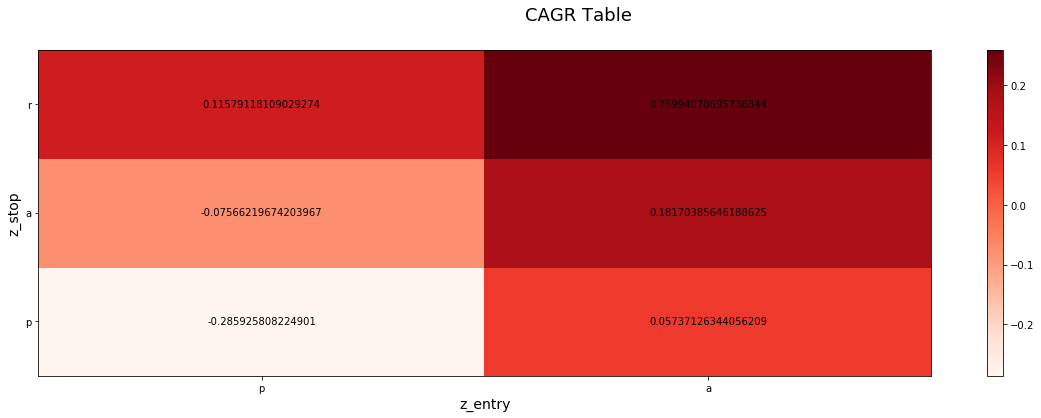

In [19]:
plot_optimization(results_df, param_a="z_entry", param_b="z_stop",  metric="cagr", title_str="CAGR Table")

## In-Sample and Out-Sample Backtest


The results after otimization in PETR3 and PETR4 look nice, but to confirm if our result is more confiable, let's test against our out sample data:

In [20]:
stockA, stockB = "PETR3", "PETR4"
in_df, out_df, in_stats_df, out_stats_df, results_df = back_inout_complete(insample_df, outsample_df, "PETR3", "PETR4", debug=False)
print_results(out_stats_df)

,Stock A,Stock B,Total Trades,Hit Ratio,CAGR,Sharpe Ratio,Return
0,PETR3,PETR4,12,0.75,1.69,0.098603,1.69


- __Total:__ 12 Trades
- __CAGR:__ 169% 
- __Sharpe Ratio__: 0.09
- __Return__: 169%
- __Win Ratio__: 75%

As we can see the results keep even in a out of sample test. We can plot the both Equity curve to have a more clear visualization. (The red line split in-sample and out-sample period):

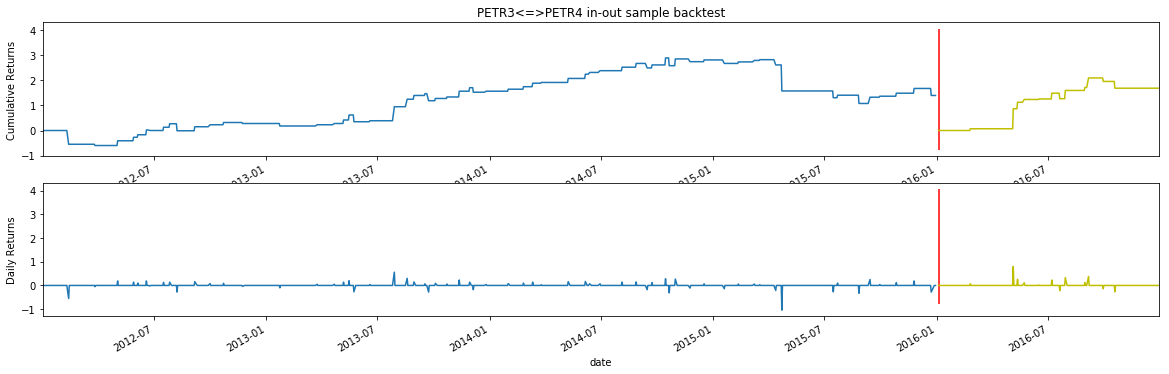

In [21]:
plot_insample_outsample(in_df, out_df, in_stats_df);

As we can see result in outsample are not soo good, in insample period.

## Table of Results of All Backtests together

In the final part of this work, we will test a lot of pair to see whats of this, the list tested will be the list of pairs genereted in *Selection Pairs using Cointegration/Correlation Test Pair* (The first topic of this work), Below the results found:


In [22]:
def back_inout_from_list(list_stocks, insample_df, outsample_df, debug=False):
    results = []
    for row in list_stocks.iterrows():
        
        stock_A, stock_B = row[1]["Stock A"], row[1]["Stock B"]
        if debug: print("debug: {}-{}".format(stock_A, stock_B))
        in_df, out_df, in_stats, out_stats, results_df = back_inout_complete(insample_df, outsample_df, stock_A, stock_B)
        
        if debug: 
            filename = "{}{}_r.csv".format(stock_A, stock_B)
            results_df.to_csv(filename, sep=";", decimal=",")
            print("end results: {} --> {}".format(filename, out_stats) )
        
        results.append(out_stats)

    return results

pairs_results_df = back_inout_from_list(pairs_df, insample_df, outsample_df, debug=False)

In [23]:
pairs_results_df_1 = pd.DataFrame(pairs_results_df)

pairs_results_df_1.sort_values("cagr", ascending=False)

,A,B,cagr,final_acc,hit_ratio,return,sharpe_ratio,start_acc,trades,trades_loss,trades_win
7,VALE3,BBAS3,9.73,10.73,0.750000,9.73,0.083471,1,8,2,6
14,UGPA3,ABEV3,9.21,10.21,0.875000,9.21,0.112478,1,8,1,7
1,BVMF3,ITUB3,5.53,6.53,0.857143,5.53,0.103714,1,7,1,6
16,GOAU4,VALE5,3.11,4.11,0.500000,3.11,0.044524,1,10,5,5
0,BVMF3,ITUB4,2.35,3.35,0.714286,2.35,0.072136,1,7,2,5
4,ITSA4,BVMF3,1.73,2.73,0.722222,1.73,0.057579,1,18,5,13
8,GOAU4,BBAS3,1.56,2.56,0.666667,1.56,0.027903,1,6,2,4
15,VALE3,USIM5,1.52,2.52,0.333333,1.52,0.016663,1,6,4,2
13,VALE5,GGBR4,1.17,2.17,0.500000,1.17,0.029247,1,8,4,4
9,GGBR4,BBAS3,0.27,1.27,0.375000,0.27,0.006933,1,8,5,3


As we can see the best pair was __BVMF3/ITUB3__, we get this result in __out of sample period__:

- __Total:__ Just 7 Trades
- __CAGR:__ 553% 
- __Sharpe Ratio__: 0.10
- __Return__: 553%
- __Win Ratio__: 85,71%

Below the equity curve of in-sample and out-sample test:

,A,B,cagr,final_acc,hit_ratio,return,sharpe_ratio,start_acc,trades,trades_loss,trades_win
0,BVMF3,ITUB3,5.53,6.53,0.857143,5.53,0.103714,1,7,1,6


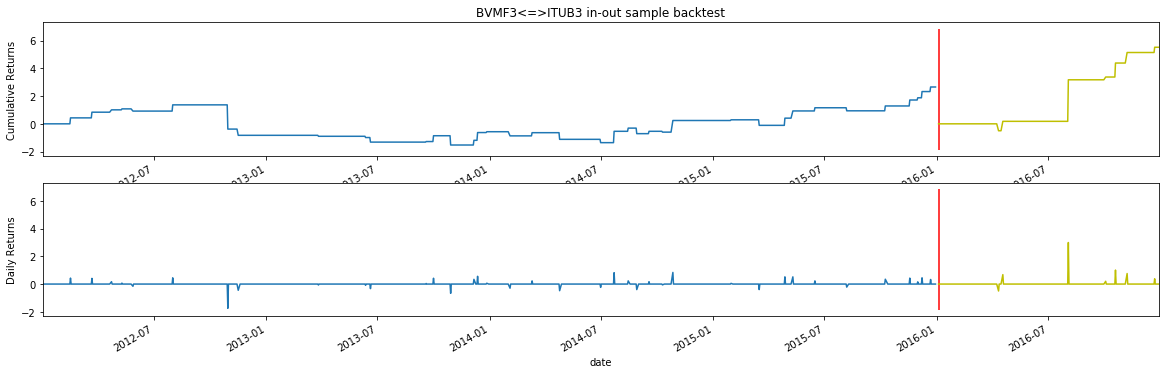

In [24]:
in_df, out_df, in_stats, out_stats, results_df = back_inout_complete(insample_df, outsample_df, "BVMF3", "ITUB3")
plot_insample_outsample(in_df, out_df, in_stats)
pd.DataFrame(out_stats, index=[0])

#### Some thought about results:
* Less Trades
* Can be overfitted, perform poorly all period, just in the end start perform better.

### Results of Second Table

I made a second table to see how this strategy perform with other pairs, i this list we have a sector column, thats its the sector of company (or can be "same", that means is same company)

below the results founded:

In [26]:
same_company = [
    ('PETR3', 'PETR4'),
    ('VALE3', 'VALE5'),
    ('ITUB3', 'ITUB4'),
]

banking_stocks = [
    ('ITSA4', 'ITUB4'),
    ('BBDC4', 'BBDC3'),
    ('BBAS3', 'ITUB4'),
]

services_stocks = [
    ('ABEV3', 'CIEL3'),
    ('LREN3', 'LAME4'),
    ('CIEL3', 'BVMF3'),
]

others_stocks = [
    ('GGBR4', 'GOAU4'),
]

def build_list_df(tuple_list, description="Sector", vl_description="-"):
    df = pd.DataFrame(tuple_list, columns=["Stock A", "Stock B"])
    df[description] = vl_description
    return df



df = build_list_df(same_company, vl_description=" Same Company")
df1 = build_list_df(banking_stocks, vl_description="Banking")
df2 = build_list_df(services_stocks, vl_description="Services")

other_list_df =  pd.concat([df, df1, df2])
other_list_df


other_list_results_df = back_inout_from_list(other_list_df, insample_df, outsample_df, debug=False)

In [27]:
pairs_results_df_2 = pd.DataFrame(other_list_results_df)

pairs_results_df_2.sort_values("cagr", ascending=False)

,A,B,cagr,final_acc,hit_ratio,return,sharpe_ratio,start_acc,trades,trades_loss,trades_win
2,ITUB3,ITUB4,7.37,8.37,0.764706,7.37,0.144039,1,17,4,13
0,PETR3,PETR4,1.69,2.69,0.750000,1.69,0.098603,1,12,3,9
7,LREN3,LAME4,0.49,1.49,0.625000,0.49,0.013640,1,8,3,5
1,VALE3,VALE5,0.14,1.14,0.727273,0.14,0.003697,1,11,3,8
4,BBDC4,BBDC3,-0.04,0.96,0.538462,-0.04,-0.002222,1,13,6,7
5,BBAS3,ITUB4,-0.27,0.73,0.555556,-0.27,-0.005745,1,9,4,5
6,ABEV3,CIEL3,-0.49,0.51,0.500000,-0.49,-0.014476,1,4,2,2
8,CIEL3,BVMF3,-0.75,0.25,0.500000,-0.75,-0.028374,1,8,4,4
3,ITSA4,ITUB4,-6.68,-5.68,0.200000,-6.68,-0.078105,1,10,8,2


As we can see the best pair was __ITUB3 <=> ITUB4__, we get this results in __out of sample period__:

- __Total:__ 17 Trades
- __CAGR:__ 737% 
- __Sharpe Ratio__: 0.14
- __Return__: 737%
- __Win Ratio__: 76,47%

Below the equity curve of in-sample and out-sample test:

,A,B,cagr,final_acc,hit_ratio,return,sharpe_ratio,start_acc,trades,trades_loss,trades_win
0,ITUB3,ITUB4,7.37,8.37,0.764706,7.37,0.144039,1,17,4,13


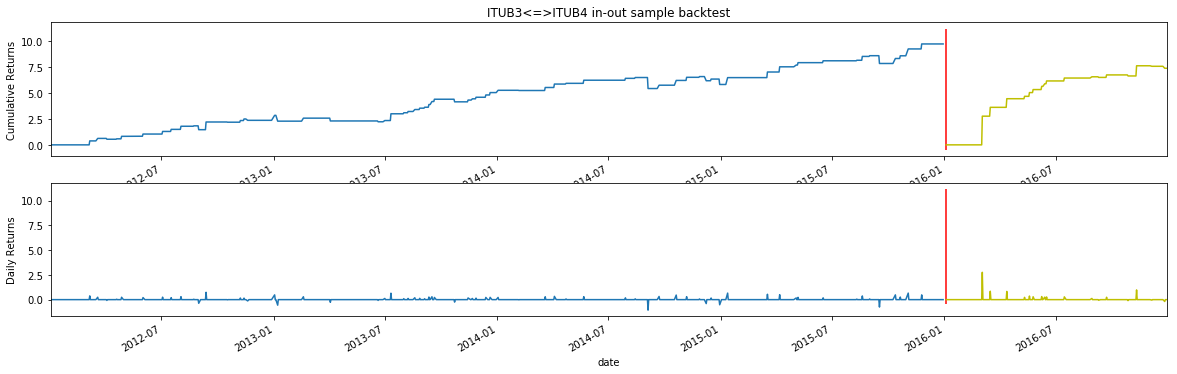

In [28]:
in_df2, out_df2, in_stats2, out_stats2, results_df2 = back_inout_complete(insample_df, outsample_df, "ITUB3", "ITUB4")
plot_insample_outsample(in_df2, out_df2, in_stats2)
pd.DataFrame(out_stats2, index=[0]).tail(1)

## Conclusion and Further Resource

First of all, sorry by my english, is not good. For sure, in a real world, all of this function and piece of code we should be absolutly sure everythings is set and valid, all those validation was take aside to code be more clear and more focused on data analysis. Another important point, is the frequency, if we wanna take trades in intraday period we must use bid ask price to calculate pnl, because, the bid-ask spread can broke a strategy on real market.


__To further resources__, we can use this pseudo-vectorized way to build a backtest it's easy to explore more tools to see if improve our test (was not cover in this work):
* filters like: Test Hurst,  Kalman Filter.

* Using some machine learn.

* Use hedge ratio instead of PairRatio, that means, calculate a linear regression between two stocks, and instead use the pair ratio, use the residual of this linear regression.

* Use hill-climb otimization or cmae, to not iterate in all options in a backtest


Thanks to QuantInsti Team to all support.

## References
* Introduction to Pair Trading (Quantopian, 2017). link: https://www.quantopian.com/lectures/introduction-to-pairs-trading

* Lecture Statistical Arbitrage (QuantInsti, 2017) 

* Book Mean Reversion Trading Systems (Howard, 2016) 

* http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#ARIMA=
* http://machinelearningmastery.com/time-series-data-stationary-python/
